#### Beer Recommender System using Collaborative Filtering (item-item similarity)

The **goal** of this project was to create a recommender system that will take a beer name as an input and return the top N recommendations based on item similiarity. Content based recommendations was explored in a different notebook but the goal was to return recommendations that are varied and not just more of the same (which is what the content-base recommender would do). For example, if I like IPA beers I want to also explore non-IPA beers that may have similar charteristics but are different enough to be categorized as a different class of beer. 
  
The Data:
* 56 subcategories of beer
* 4964 unique beers
* ~88K unique users
* ~1.4M user-review pairings

Data was scraped from a popular beer review website: https://www.beeradvocate.com/
  

Main Tools:   
Surprise Library - http://surpriselib.com/  
scikitleran: https://scikit-learn.org/stable/

NOTE: some of the below functions and code descriptions were taken directly from the Surprise Library Documentation

---

In [1]:
import sys
import pandas as pd
import numpy as np
import re
import csv
import unicodedata
import sys
import time
import pickle
import copy

from collections import defaultdict

from surprise import SVD, evaluate, KNNBasic, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBaseline, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

from scipy import spatial

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

import warnings
warnings.filterwarnings("ignore")

---
#### Load user reviews data

Beer and User Review pairings were stored on a MONGODB database hosted on AWS. For the purpose of this notebook, the data was pulled from AWS and stored as a dataframe object on a local machine. 

In [2]:
pickle_in = open('compiled_ratings_df.pickle','rb')
user_reviews_df = pickle.load(pickle_in)

#### A little bit of EDA and Cleaning

In [3]:
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427301 entries, 0 to 188328
Data columns (total 3 columns):
beer_name    1427301 non-null object
user         1427301 non-null object
rating       1427301 non-null float64
dtypes: float64(1), object(2)
memory usage: 43.6+ MB


In [4]:
user_reviews_df.head()

,beer_name,user,rating
0,Sumatra Mountain Brown (Barrel-Aged),rabbott2,3.50
1,Sumatra Mountain Brown (Barrel-Aged),jhavs,4.04
2,Sumatra Mountain Brown (Barrel-Aged),lupercmda,4.50
3,Sumatra Mountain Brown (Barrel-Aged),Dicers,4.06
4,Sumatra Mountain Brown (Barrel-Aged),RAlmeida77,4.49


In [5]:
user_reviews_df.iloc[0].beer_name

'Sumatra Mountain Brown (Barrel-Aged) '

In [6]:
user_reviews_df.iloc[0].user

'rabbott2'

In [7]:
def remove_space(string):
    """
    to remove space at end of beer name
    """
    try:
        assert isinstance(string, str)
    except AssertionError:
        raise TypeError('Invalid input, this function expects string inputs.')
    return string.rstrip()

In [8]:
assert remove_space('test case ') == 'test case'

In [9]:
user_reviews_df.beer_name = user_reviews_df.beer_name.apply(lambda x: remove_space(x))

In [10]:
user_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427301 entries, 0 to 188328
Data columns (total 3 columns):
beer_name    1427301 non-null object
user         1427301 non-null object
rating       1427301 non-null float64
dtypes: float64(1), object(2)
memory usage: 43.6+ MB


In [11]:
user_reviews_df.iloc[0].beer_name

'Sumatra Mountain Brown (Barrel-Aged)'

In [12]:
user_reviews_df.describe()

,rating
count,1.427301e+06
mean,4.144708e+00
std,5.686697e-01
min,1.000000e+00
25%,3.890000e+00
50%,4.250000e+00
75%,4.500000e+00
max,5.000000e+00


The average rating for these beers are between 4.14 and 5.0. This makes sense since these beers were scraped from "top 100" lists across 56 subcategories.

---

Histogram of review counts

Text(0.5,1,'Histogram of Review Counts')

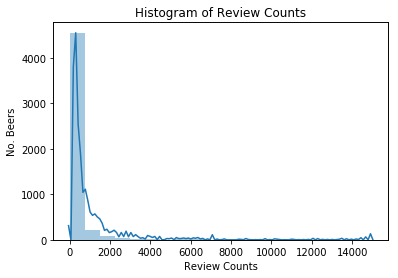

In [13]:
data= user_reviews_df.beer_name.value_counts()

# Plotting hist without kde
ax = sns.distplot(data, bins=20, kde=False)

# Creating another Y axis
second_ax = ax.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data, ax=second_ax, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax.set_yticks([])

# Set labels
ax.set_xlabel('Review Counts')
ax.set_ylabel('No. Beers')
ax.set_title("Histogram of Review Counts")

In [14]:
grouped_beers = user_reviews_df.groupby('beer_name')

In [15]:
grouped_beers.count().sort_values(by='user', ascending = False).quantile(np.arange(0,1,.05))

,user,rating
0.00,9.0,9.0
0.05,10.0,10.0
0.10,12.0,12.0
0.15,15.0,15.0
0.20,17.0,17.0
0.25,20.0,20.0
0.30,23.0,23.0
0.35,26.0,26.0
0.40,32.0,32.0
0.45,38.0,38.0


About 80% of the beers have less than 200 rating counts

---

Now lets look at the quantiles per average ratings

In [16]:
grouped_beers.mean().sort_values(by='rating', ascending = False).quantile(np.arange(0,1,.05))

,rating
0.00,1.411667
0.05,3.134533
0.10,3.482338
0.15,3.666250
0.20,3.732960
0.25,3.777675
0.30,3.816875
0.35,3.846800
0.40,3.879584
0.45,3.911394


In [17]:
avg_rating = grouped_beers.mean()

# I am definining beers with average rating less than 3.5 to be considered subpar 
# since a 3.5 avg rating would put it in the bottom 10 percentile of these beers
subpar_average_mask = avg_rating['rating'] < 3.5
subpar_beers_count = len(avg_rating[subpar_average_mask])

print('{} beers have a average rating less than 3.5'.format(subpar_beers_count))
print('A 3.5 avg rating puts the beer within the bottom 10%-tile')

518 beers have a average rating less than 3.5
A 3.5 avg rating puts the beer within the bottom 10%-tile


In [18]:
# distribution of the bottom 10% in average rating, and number of rating counts
bottom_10percent_rating = grouped_beers.mean().quantile(np.arange(0,.11,.01))
bottom_10percent_counts = grouped_beers.count().quantile(np.arange(0,.11,.01))

In [19]:
bottom_10percent_rating

,rating
0.00,1.411667
0.01,2.464294
0.02,2.716124
0.03,2.896602
0.04,3.038345
0.05,3.134533
0.06,3.224937
0.07,3.314658
0.08,3.370548
0.09,3.433212


In [20]:
bottom_10percent_counts

,user,rating
0.00,9.0,9.0
0.01,9.0,9.0
0.02,9.0,9.0
0.03,10.0,10.0
0.04,10.0,10.0
0.05,10.0,10.0
0.06,11.0,11.0
0.07,11.0,11.0
0.08,11.0,11.0
0.09,12.0,12.0


The bottom 10%-tile in terms of avg ratings are anywhere from 1.41 to 3.48  
The bottom 10%-tile in terms of number of ratings are anywhere from 9 to 12

---

Now lets take a look at the users

Text(0.5,1,'Histogram of User Counts')

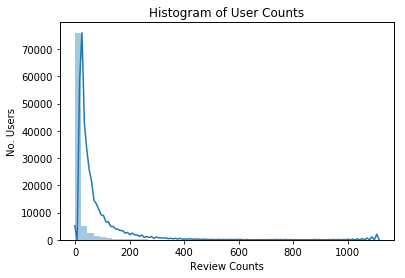

In [21]:
data2= user_reviews_df.user.value_counts()

# Plotting hist without kde
ax2 = sns.distplot(data2, kde=False)

# Creating another Y axis
second_ax2 = ax2.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data2, ax=second_ax2, kde=True, hist=False)

#Removing Y ticks from the second axis
second_ax2.set_yticks([])

# Set labels
ax2.set_xlabel('Review Counts')
ax2.set_ylabel('No. Users')
ax2.set_title("Histogram of User Counts")

In [22]:
grouped_users = user_reviews_df.groupby('user')

In [30]:
grouped_users_count = grouped_users.count()

counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['rating'] <= ct].count()[0]
    print('{} users rated {} or less beers'.format(num_users,ct))

print('\n')
print('Total Unique Users in this dataset: {}'.format(len(user_reviews_df.user.unique())))

31898 users rated 1 or less beers
44384 users rated 2 or less beers
51242 users rated 3 or less beers
55753 users rated 4 or less beers
59126 users rated 5 or less beers
67935 users rated 10 or less beers
72093 users rated 15 or less beers
74714 users rated 20 or less beers


Total Unique Users in this dataset: 88600


The vast majority of the users rated only a few beers, with more than half of the users having rated less than 5 beers.

---

<br/>

To improve results of the recommender, the beers in the bottom 10 percent in terms of avg rating and review counts will be removed. This will remove about 20% of the beers, bringing the unique beers count from 4964 to 3960.

NOTE:
When using the Surprise library, the "shringkage factor" (for imputing missing ratings) takes into account the number of reviews for each item/user. It punishes the items/users with very little reviews. Therefore this step is not critical.

In [37]:
subpar_beers_list = list(avg_rating[subpar_average_mask].index)

ratings_count = grouped_beers.count()

# I am definining beers with ratings count less than 13 to be considered low amount of ratings 
# since a ratings count of 13 would put it in the bottom 10 percentile
low_ratings_count = ratings_count[ratings_count['rating'] < 13]
low_ratings_list = list(low_ratings_count.index)

In [39]:
unique_subpar_beers = set(subpar_beers_list)
unique_low_ratings_beers = set(low_ratings_list)
overlaps = unique_subpar_beers.intersection(unique_low_ratings_beers)
print('Number of beers in bottom 10% of avg rating: {}'.format(len(unique_subpar_beers)))
print('Number of beers in bottom 10% of review counts: {}'.format(len(unique_low_ratings_beers)))
print('Number of beers in both of these categories: {}'.format(len(overlaps)))

Number of beers in bottom 10% of avg rating: 518
Number of beers in bottom 10% of review counts: 544
Number of beers in both of these categories: 56


In [40]:
#remove beers in the bottom 10% of both categories
df1 = user_reviews_df[~user_reviews_df.beer_name.isin(subpar_beers_list)]
df2 = df1[~df1.beer_name.isin(low_ratings_list)]
user_reviews_df2 = copy.deepcopy(df2)

In [41]:
user_reviews_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1351367 entries, 0 to 188328
Data columns (total 3 columns):
beer_name    1351367 non-null object
user         1351367 non-null object
rating       1351367 non-null float64
dtypes: float64(1), object(2)
memory usage: 41.2+ MB


In [43]:
print('Original number of unique beers: {}'.format(len(user_reviews_df.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(user_reviews_df2.beer_name.unique())))

Original number of unique beers: 4965
Revised number of unique beers: 3959


---

### Buidling the model with Surprise

<br/>


**From the Surprise Library Documentation**

What are raw and inner ids?
Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know if you’re using e.g. predict() or other methods that accept raw ids as parameters.

On trainset creation, each raw id is mapped to a unique integer called inner id, which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.

---

  
  
_The below code creates raw and inner ids for each beer and user_

In [54]:
# create beerID for each beer

grouped_name = user_reviews_df2.groupby('beer_name')

temp_df = grouped_name.count()
temp_df_idx = pd.DataFrame(temp_df.index)


temp_df_idx['beerID'] = temp_df_idx.index
dict_df=temp_df_idx[['beerID','beer_name']]


desc_dict = dict_df.set_index('beer_name').to_dict()
new_dict = desc_dict['beerID']

user_reviews_df2['beerID'] = user_reviews_df2.beer_name.map(new_dict)



# create userID for each user
grouped_user = user_reviews_df2.groupby('user')

temp_df_user = grouped_user.count()
temp_df_user_idx = pd.DataFrame(temp_df_user.index)


temp_df_user_idx['userID']=temp_df_user_idx.index
dict_df_user=temp_df_user_idx[['userID','user']] 


desc_dict_user = dict_df_user.set_index('user').to_dict()
new_dict_user = desc_dict_user['userID']

user_reviews_df2['userID'] = user_reviews_df2.user.map(new_dict_user)

---

_Below code was taken from Surpirse Library Documentation  and modified_

In [45]:
def read_item_names():
    """
    return two mappings to convert raw ids into beer names 
    and beer names into raw ids.
    """

    file_name = dict_df
    rid_to_name = {}
    name_to_rid = {}

    # there are 3959 unique beers after removing the low rating and review count beers
    unique_beers = len(user_reviews_df2.beer_name.unique())
    
    for i in range(unique_beers):  
        line = file_name.iloc[i]
        rid_to_name[line[0]] = line[1]
        name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

In [46]:
def get_rec(beer_name, k_):
    """
    Input Beer name and returns k recommendations
    based on item similarity
    
    Input: String, integer
    Output: String
    """
    output = []
    
    beer = str(beer_name)

    # Read the mappings raw id <-> beer name
    rid_to_name, name_to_rid = read_item_names()

    # Retrieve inner id of the Beer
    beer_input_raw_id = name_to_rid[beer]
    beer_input_inner_id = algo.trainset.to_inner_iid(beer_input_raw_id)

    
    K = k_
    
    # Retrieve inner ids of the nearest neighbors of the Beer
    beer_input_neighbors = algo.get_neighbors(beer_input_inner_id, k=K)

    
    # Convert inner ids of the neighbors into names.
    beer_input_neighbors = (algo.trainset.to_raw_iid(inner_id)
                                for inner_id in beer_input_neighbors)
    beer_input_neighbors = (rid_to_name[rid]
                                for rid in beer_input_neighbors)

    for beer_ in beer_input_neighbors:
        output.append(beer_)
        
    return output

Building the model with Surprise using the KNN Baseline algorithm and Pearson Baseline similarity for item-item comparison. In other words, this recommender system is an item based CF recommender that uses a nearest neighbors appproach as oppose to latent factors (SVD). The Similarity is based on Pearson correlation as oppose to cosine distance or MSD. Please check out the Suprise Library documentation for more information: https://surprise.readthedocs.io/en/stable/

In [48]:
# Train the algortihm to compute the similarities between items (item-item collaborative filtering)
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(user_reviews_df2[['userID', 'beerID', 'rating']], reader)
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Evaluate the performance using Surprise's evaluation module
evaluate(algo, data, measures=['RMSE', 'MAE'])

In [50]:
# top 20 most rated beers
grouped_beer_names = user_reviews_df2.groupby('beer_name')
grouped_beer_names.count().sort_values(by='user', ascending =False)[0:20].index.tolist()

['Two Hearted Ale',
 'Pliny The Elder',
 'Sculpin IPA',
 'Heady Topper',
 'Hopslam Ale',
 'KBS (Kentucky Breakfast Stout)',
 'Bourbon County Brand Stout',
 'Old Rasputin',
 'Enjoy By IPA',
 'Prima Pils',
 'Zombie Dust',
 'Ten FIDY',
 "A Little Sumpin' Sumpin' Ale",
 'Weihenstephaner Hefeweissbier',
 'Jai Alai IPA',
 'Porter',
 'Oberon Ale',
 'Bourbon County Brand Coffee Stout',
 'Victory At Sea - Coffee And Vanilla',
 'The Abyss']

In [51]:
# top 20 highest rating beers
grouped_beer_names.mean().sort_values(by='rating', ascending =False)[0:20].index.tolist()

['Kentucky Brunch Brand Stout',
 'Derivation Blend #9 (Cinnamon/Maple)',
 'Elysium',
 'Monster Tones',
 'It Was All A Dream',
 'Double Tapped',
 'I Let My Tape Rock',
 'Double Shot - Vanilla',
 'Barrel-Aged Abraxas',
 'Oude Fermier',
 'King Julius',
 'Marshmallow Handjee',
 'Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow',
 'King JJJuliusss',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Barrel Aged Imperial German Chocolate Cupcake Stout',
 'Chemtrailmix (2018)',
 'Very Hazy',
 'Heady Topper',
 'SR-71']

In [57]:
print('The 20 nearest neighbors of Kentucky Brunch Brand Stout are:')
get_rec('Kentucky Brunch Brand Stout',20)

The 20 nearest neighbors of Kentucky Brunch Brand Stout are:


["Mornin' Delight",
 'Sweet Action',
 'Light Speed',
 'Franziskaner Hefe-Weisse',
 'Assassin',
 'SR-71',
 'Grassroots Convivial Suaréz',
 'Bu Weisse',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Chocolate Rain',
 'Framboise Du Fermier',
 'Moat Water',
 'Dortmunder Gold',
 'Coffee And Cigarettes',
 'Double Dry Hopped Double Mosaic Dream',
 'Cask Strawberry',
 'Leffe Blonde',
 'Weihenstephaner 1516 Kellerbier',
 'Nelson Dry Hopped Fort Point',
 'King Sue']

In [56]:
print('The 20 nearest neighbors of Two Hearted Ale are:')
get_rec('Two Hearted Ale',20)

The 20 nearest neighbors of Two Hearted Ale are:


['Hopslam Ale',
 'Ella',
 'Sculpin IPA',
 'IPA - Double Dry-Hopped',
 'Mocha Marlin',
 'Hacker-Pschorr Munchner Kellerbier (Anno 1417)',
 'Big Red Coq',
 'Hop Program - Beer I',
 'Bohemian Pilsner',
 'Amber Ale',
 'Fathom IPL',
 'Weihenstephaner Pils',
 'Society & Solitude #6',
 'Jai Alai IPA',
 'Noble Prize',
 'Smokestack Heritage Porter',
 'Metric',
 'Oberon Ale',
 'Fade To Black - Volume 1',
 'This Town']

In [58]:
top20rated = user_reviews_df2.groupby('beer_name').count().sort_values(by='user', ascending =False)[0:20].index.tolist()
top20rated = set(top20rated)

top20rating = user_reviews_df2.groupby('beer_name').mean().sort_values(by='rating', ascending =False)[0:20].index.tolist()
top20rating = set(top20rating)

kbbs = set(get_rec('Kentucky Brunch Brand Stout',20))
tha = set(get_rec('Two Hearted Ale',20))

In [59]:
print(kbbs.intersection(top20rated))
print(kbbs.intersection(top20rating))

set()
{'SR-71', "Hunahpu's Imperial Stout - Double Barrel Aged"}


In [60]:
print(tha.intersection(top20rated))
print(tha.intersection(top20rating))

{'Jai Alai IPA', 'Sculpin IPA', 'Oberon Ale', 'Hopslam Ale'}
set()


As you can see above, when I inputed the most rated beer (higest review counts), 'Two Hearted Ale', the recommendations only contained four beers that were in the top 20 most rated list. 

Likewise, when I inputed the highest rating beer (higest average rating), 'Kentucky Brunch Brand Stout', the recommendations only contained 2 beers that were in the top 20 highest ratings list.

This is desirable since the goal of collaborative filtering is to find most similar items based on how users rated them, or vice versa, the recommendations should not be giving more of the same beers (in this case, the highest rated beers or the beers with the highest ratings). For best results, a hybrid system that utilizes content-based filtering along with collaborative filtering would be best.

Testing a couple more:

In [61]:
ebi = set(get_rec('Enjoy By IPA',20))
mbp = set(get_rec('Maple Bacon Coffee Porter',20))

In [62]:
print(ebi.intersection(top20rated))
print(ebi.intersection(top20rating))
print(mbp.intersection(top20rated))
print(mbp.intersection(top20rating))

{'Sculpin IPA'}
set()
set()
set()


In [63]:
print('The 20 nearest neighbors of Enjoy By IPA:')
ebi

The 20 nearest neighbors of Enjoy By IPA:


{'All Green Everything',
 'BFF',
 'Black Watch Double Chocolate Milk Stout',
 'Blazing World',
 'Evil Twin',
 'Field To Ferment: Citra',
 'G-Bot Double IPA',
 'Grapefruit Sculpin',
 'Humulus Lager',
 'Lunch',
 'Ma',
 'Nightmare On Brett - Bourbon Barrel',
 'Pallet Jack IPA',
 'Pataskala Red X IPA',
 'Project Dank',
 'Sculpin IPA',
 'Stone / Chris Banker / Insurgente - Xocoveza',
 "Sweet Tat's Breakfast Stout (Underground Series)",
 'Weihenstephaner Hefeweissbier Dunkel',
 'Weihenstephaner Pils'}

In [64]:
print('The 20 nearest neighbors of Maple Bacon Coffee Porter:')
mbp

The 20 nearest neighbors of Maple Bacon Coffee Porter:


{'Flora Blueberry/Black Currant/Raspberry',
 'Framinghammer - Bourbon Barrel-Aged',
 'Fyodor',
 'HOPSMACK!',
 'Last Snow',
 'Lunch',
 'Madagascar',
 'Morning Wood',
 'Mott The Lesser',
 'Neapolitan Porter',
 'Neumarkter Lammsbräu (Organic) Pilsner',
 'Nib Smuggler',
 'Single Shot W/ Vanilla Bean',
 'Society & Solitude #5',
 'Sosus',
 'Spencer Trappist Ale',
 'The Love Below',
 'Tovarish',
 'Von Pilsner',
 "Wide Awake It's Morning"}

'Enjoy by IPA' is an IPA (Indian Pale Ale) beer. And while the top 20 list for 'Enjoy by IPA' return quite a few other IPAs, there were also stouts and an amber ale among others. 

The top 20 list for 'Maple Bacon Coffee Porter' return a more varied list with porters, stouts, IPA and other ales, although most of these beers tend to be on the heavier side with a higher alcohol content and full bodied.

These are desirable results since we want a recommendation engine to give some variety and not just more of the same.

---

### Building a model with sk-learn: latent factors approach

Alternatively, we can use a latent factors approach by using a Truncated SVD. The surprise package also have an algorithm for doing SVD instead of the KNN method, however, it would require some deep dive into the code and making some modification in order to be able to run a truncated SVD. The default SVD module does not allow for a truncated SVD. The reason, why a truncated SVD is needed is because a standard SVD would require too much memory and processing power. Given that we have a matrix of about 5K x 88K, it would not be feasible.


In [65]:
# create pivot table and make it sparse (impute NANs with 0s)
user_reviews_df2_pivot = user_reviews_df2.pivot_table(index='user', columns='beer_name', values='rating').fillna(0)

In [66]:
user_reviews_df2_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85713 entries, --- to zzurn
Columns: 3959 entries, #Merica to Štěpán - český Klasický Ležák Světlý
dtypes: float64(3959)
memory usage: 2.5+ GB


In [67]:
T = user_reviews_df2_pivot.values.T
T.shape

(3959, 85713)

Using explained variance to determine the number of components for this Truncated SVD

In [68]:
def exp_var(list_n_components):
    '''
    input: list of integers
    output: list of tuples showing n_components and it's explained variance ratio
    '''
    
    out = []
    
    for num in list_n_components:
        SVD = TruncatedSVD(n_components=num,random_state=num)
        SVD.fit_transform(T)
        evar = np.sum(SVD.explained_variance_ratio_)
        t = (num,evar)
        out.append(t)
    
    return out

In [69]:
n_comp = [5,10,20,50,100,200,300]
explained_variance = exp_var(n_comp)

In [70]:
[print(i) for i in explained_variance]

(5, 0.2824486509799812)
(10, 0.32795608283752675)
(20, 0.3813270995283478)
(50, 0.4746928589626328)
(100, 0.5665366381144177)
(200, 0.674341839123503)
(300, 0.7423358460483446)


[None, None, None, None, None, None, None]

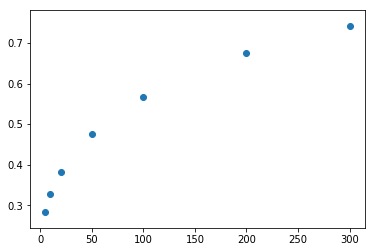

In [71]:
x,y = zip(*explained_variance)
plt.scatter(x, y)

Based on the above information, I decided to use 200 components for this truncated svd. I believe this is fair given that there is only 3900 unique beers over 56 subcategories, and at 200 components the model captures 2/3 of the explained variance.

Each component is a latent feature that a particular beer and user has an affinity to, and given that there is only 3900 beers, you can say that there are 20 (3900 divide by 200) beers per latent factor. 

Another way to think about this is to think about how many differnt ways you can classify or describe the types of beers that are avaiable. Even within the 56 subcategories, many of these subcategories are very similar to one another, most people probably wouldn't be able to tell the difference. However, these latent factors encapsulate features that are hard to explain. For example, a particular latent factor could be charaterized as "slightly hoppy + low alcohol content + light bodied + high carbonation" or a particular subcategory. 

Therefore, if you think about the different criterias of charterizing beers, they may be:
* bitterness/hoppines
* sweetness level
* carbonation level
* nose/aroma 
* body of the beer

Lets say there are 3 levels for each criteria (high,mid,low), then there are 243 combinations (3 to the 5th power) - and that is assuming each criteria is independent of each other which is not the case (hoppy beers tend to have a strong aroma, sweeter beers have a full body). 

---

Create the 200 component Truncated SVD

In [73]:
SVD200 = TruncatedSVD(n_components=200,random_state=200)
matrix200 = SVD200.fit_transform(T)
matrix200.shape

(3959, 200)

In [74]:
# correlation/similarity matrix
corr200 = np.corrcoef(matrix200)
corr200.shape

(3959, 3959)

In [76]:
# name of all beers
beer_rec_names200 = user_reviews_df2_pivot.columns

# list of all beer names
beer_rec_list200 = list(beer_rec_names200)

In [77]:
def svd200_recs(string,n):
    """
    function returns top n recommendations base on input of beer name and n.
    
    inputs: 
    string (name of beer) -> string
    n (n recommendations) ->  int
    """
    
    # get index of beer name from list of all beers in the training data
    get_index = beer_rec_list200.index(string)
    
    # similarity coeff of all other beers w respect to the input beer
    similarities = corr200[get_index]
    
    # create  & popluate list to hold tuples of beer names and their 
    # respective correlation coeff, sorted in reverse
    closest = []    
    for idx, coeff in enumerate(similarities):
        closest.append((beer_rec_list200[idx],coeff))
    
    closest.sort(key=lambda x: x[1], reverse=True)
    
    out = []
    
    for i in range(1,n+1):
        out.append(closest[i][0])
    return out

Lets get the top 20 recommendations for the same beers we looked at earlier

In [78]:
svd200_recs('Kentucky Brunch Brand Stout',20)

['Assassin',
 'SR-71',
 "Mornin' Delight",
 'Barrel-Aged Abraxas',
 "Hunahpu's Imperial Stout - Double Barrel Aged",
 'Barrel-Aged Sump Coffee Stout',
 'Beer Geek Vanilla Shake - Bourbon Barrel-Aged',
 'Saison Du Fermier',
 'Coffee Abraxas',
 'Beyond Good And Evil',
 'Framboise Du Fermier',
 'Barrel-Aged Silhouette',
 'Pugachev Royale',
 'Marshmallow Handjee',
 'Abricot Du Fermier',
 'Grande Negro Voodoo Papi - Bourbon Barrel-Aged',
 'Maman',
 'Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged',
 'Fundamental Observation',
 'DFPF']

In [79]:
# Latent Factors method
A = set(svd200_recs('Kentucky Brunch Brand Stout',20))

# Neighborhood method
B = set(get_rec('Kentucky Brunch Brand Stout',20))

print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Framboise Du Fermier', "Hunahpu's Imperial Stout - Double Barrel Aged", 'SR-71', "Mornin' Delight", 'Assassin'}
number of common beers: 5


In [80]:
svd200_recs('Two Hearted Ale',20)

['Hopslam Ale',
 'Oberon Ale',
 'Sculpin IPA',
 'Enjoy By IPA',
 'Ten FIDY',
 'Jai Alai IPA',
 'KBS (Kentucky Breakfast Stout)',
 'Old Rasputin',
 'Porter',
 'Alpha King',
 'Bourbon County Brand Stout',
 'Edmund Fitzgerald Porter',
 'Harvest Ale',
 "A Little Sumpin' Sumpin' Ale",
 'Gumballhead',
 'Victory At Sea - Coffee And Vanilla',
 'Dreadnaught IPA',
 'Furious',
 'Zombie Dust',
 'Pliny The Elder']

In [81]:
A = set(svd200_recs('Two Hearted Ale',20))
B = set(get_rec('Two Hearted Ale',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Jai Alai IPA', 'Sculpin IPA', 'Oberon Ale', 'Hopslam Ale'}
number of common beers: 4


In [82]:
A = set(svd200_recs('Enjoy By IPA',20))
B = set(get_rec('Enjoy By IPA',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Sculpin IPA', 'Lunch', 'Grapefruit Sculpin'}
number of common beers: 3


In [83]:
A = set(svd200_recs('Elysium',20))
B = set(get_rec('Elysium',20))
print('common beers: {}'.format(A.intersection(B)))
print('number of common beers: {}'.format(len(A.intersection(B))))

common beers: {'Acerbic Ecstasy', 'Moe Beer'}
number of common beers: 2


#### Comparing the two different Method: LF vs KNN

In [84]:
def compare_recs(name_list,n):

    '''
    inputs: 
    name_list(list of beer names) -> list
    n (number of recommendations) -> integer
    
    output: 
    graph showing the number of common beers between two different CF methods for each of the input beer
    
    '''
    results = []
    
    for idx, name in enumerate(name_list):
        svd = set(svd200_recs(name,n))
        knn = set(get_rec(name,n))
        common = len(svd.intersection(knn))
        tup = (idx, common)
        results.append(tup)
    
    x,y = zip(*results)
    plt.scatter(x, y)
    plt.xlabel('Beer No.')
    plt.ylabel('Common Recs')
    plt.show()

In [85]:
# select every 40 beers from highest avg rating to lowest avg rating
grouped = user_reviews_df2.groupby('beer_name')
namelist = grouped.mean().sort_values(by='rating', ascending =False)[::40].index.tolist()

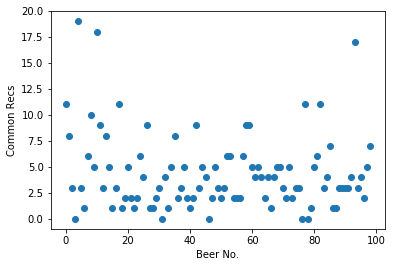

In [86]:
compare_recs(namelist,50)

The above graph shows the number of common closest beers or top recommendations from both the SVD and the nearest neighbors models for a sample of 99 beers (ranging from highest ratings to lowest ratings). As you can see, for the top 50 closest beers, the amount of overlap between the two methods ranges from 0 to 20 which translates to 0-40%. So the two different methods returns very different results and this is expected because a SVD captures relationships that the a nearest neighbor approach does not.  

---

**Conclusion:**

Building a collaborative filtering recommender system can be quite simple. The Surprise Library is a great module to use. You can use a neighbors appraoch (KNN) or a latent factors approach (SVD). Both methods may yield very differnt results, however, this may actually be a good thing as you can combine both results to create a hybrid recommeder system. Collaborative filtering is great if you want your recommendation engine to provide diverse or varied results. Otherwise you can just use a content-based recommender, which in this case would recommend mostly beers within the same subcategory. Combining results from two or all three (content-based, KNN, SVD) would probably be your best bet.  